In [1]:
from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load
from rdkit import Chem

import rdkit
from rdkit import Chem
import py3Dmol
rdkit.Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization

In [3]:
cfg = quick_load.load_cfg(overrides=['task_group=pharmit5050_cond_a'], pharmit_path='/home/ian/projects/mol_diffusion/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("val")
pharmit_dataset = train_dataset.datasets['pharmit']
ckpt_path = '/home/ian/projects/mol_diffusion/OMTRA/local/runs_from_cluster/uncond_r179_iiftoej0/checkpoints/last.ckpt'
model = quick_load.omtra_from_checkpoint(ckpt_path).cuda().eval()

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


# Denovo Ligand Sampling

## just the final ligand

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

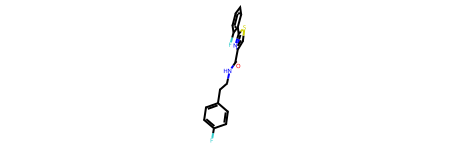

In [5]:
sampled_systems = model.sample(
    task_name='denovo_ligand_condensed',
    g_list=None,
    n_replicates=1,
    unconditional_n_atoms_dist='pharmit',
    n_timesteps=200,
)

sampled_systems[0].get_rdkit_ligand()

## sampling trajectory

In [17]:
def mols_to_sdf(mols, filename):
    sdf_writer = Chem.SDWriter(filename)
    sdf_writer.SetKekulize(False)
    for mol in mols:
        try:
            # Chem.Sanitize
            sdf_writer.write(mol)
        except Exception as e:
            print(e)
            continue
    sdf_writer.close()


def display_ligand_trajectory(sys):
    xt_traj_mols = sys.build_traj(ep_traj=False, lig=True, prot=False)['lig']
    ep_traj_mols = sys.build_traj(ep_traj=True, lig=True, prot=False)['lig']

    xt_traj_file = 'xt_traj.sdf'
    ep_traj_file = 'ep_traj.sdf'
    mols_to_sdf(xt_traj_mols, xt_traj_file)
    mols_to_sdf(ep_traj_mols, ep_traj_file)


    # visualize trajectory
    view = py3Dmol.view(width=800,height=400, linked=True, viewergrid=(1,2))

    for i, filename in enumerate([xt_traj_file, ep_traj_file]):
        with open(filename) as f:
            sdf = f.read()
        view.addModelsAsFrames(sdf, format='sdf', viewer=(0,i))
    view.addLabel("current state (gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,0))
    view.addLabel("Predicted final state (ĝ_1 given gₜ)",{'position':{'x':0,'y':0,'z':0},'useScreen': True, 'fontSize': 24}, viewer=(0,1))
    view.setStyle({'stick':{}, 'sphere':{'scale': 0.2}},)
    view.animate({'loop': 'forward', 'interval': 125},)
    view.zoomTo()
    view.zoom(0.75)
    view.show()


sys = model.sample(
    task_name='denovo_ligand',
    g_list=None,
    n_replicates=1,
    unconditional_n_atoms_dist='pharmit',
    n_timesteps=200,
    visualize=True
)[0]
display_ligand_trajectory(sys)



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Conformer Sampling

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

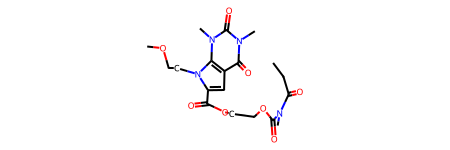

In [12]:
# get a ligand from the dataset to do conformer sampling with!
g = pharmit_dataset[('ligand_conformer', 0)].to('cuda')
g_list = [g]

sampled_systems = model.sample(
    task_name='ligand_conformer',
    g_list=g_list,
    device=g.device,
    n_replicates=1,
    unconditional_n_atoms_dist='pharmit',
    n_timesteps=200,
)

sampled_systems[0].get_rdkit_ligand()

# conformer sampling trajectory

In [16]:
# get a ligand from the dataset to do conformer sampling with!
g = pharmit_dataset[('ligand_conformer', 0)].to('cuda')
g_list = [g]

sys = model.sample(
    task_name='ligand_conformer',
    g_list=g_list,
    device=g.device,
    n_replicates=1,
    unconditional_n_atoms_dist='pharmit',
    n_timesteps=200,
    visualize=True
)[0]
display_ligand_trajectory(sys)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.